In [1]:
# @title Захват кадров
import cv2
import pandas as pd
import os
from PIL import Image

TRAIN_VAL_SPLIT = 0.2
CLASS_NAMES = ['normal', 'covered', 'defocussed', 'moved']
CLASS_TO_IDX = {
    'normal': 0,
    'covered': 1,
    'defocussed': 2,
    'moved': 3
}

class VideoFrameExtractor:
    def __init__(self, base_path, camera_name, max_frames_per_class, step=4):
        self.base_path = base_path
        self.camera_name = camera_name
        self.step = step
        self.max_frames_per_class = max_frames_per_class

    def _load_annotations(self, annotation_path):
        if not os.path.exists(annotation_path):
            return None
        df = pd.read_csv(annotation_path, header=None)
        return df.iloc[:, 1].values

    def extract(self):
        train_data = []
        val_data = []
        
        train_path = os.path.join(self.base_path, self.camera_name, "Training video")
        test_path = os.path.join(self.base_path, self.camera_name, "Testing video")
        
        for idx, path in enumerate([train_path, test_path]):
            frames_collected_total = 0
            frames_collected_per_class = [0, 0, 0, 0]
            max_frames_per_class = [x * (TRAIN_VAL_SPLIT if idx else 1) for x in self.max_frames_per_class]
                
            for root, _, files in os.walk(path):
                for file in files:
                    if not file.endswith(".avi"):
                        continue

                    video_path = os.path.join(root, file)
                    annotation_path = os.path.join(root, "annotations.csv")
                    labels = self._load_annotations(annotation_path)
                    if labels is None:
                        print(f"Warning: no annotations for {video_path}, skipping.")
                        continue

                    cap = cv2.VideoCapture(video_path)
                    total_frames = len(labels)
                    frame_idx = 0

                    while frame_idx < total_frames and frames_collected_total < sum(max_frames_per_class):
                        true_label = labels[frame_idx]
                        if frames_collected_per_class[true_label] == max_frames_per_class[true_label]:
                            frame_idx += self.step
                            continue
                        
                        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                        ret, frame = cap.read()
                        if not ret:
                            frame_idx += self.step
                            continue
                        
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        pil_img = Image.fromarray(frame)
                        if idx == 0: # train and val
                            train_data.append((pil_img, true_label))
                        else: # test
                            val_data.append((pil_img, true_label))
                            
                        frames_collected_total += 1
                        frames_collected_per_class[true_label] += 1
                        frame_idx += self.step
                        

                    cap.release()

            print(f"Extracted per {"train+test" if idx == 0 else "val"} : {frames_collected_per_class}") 
                
                         
        return train_data, val_data


In [2]:
from torch.utils.data import Dataset

class FrameDataset(Dataset):
    def __init__(self, frame_data, transform=None):
        self.frame_data = frame_data
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.frame_data[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.frame_data)


In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

# 60/20/20

class ImageDataset(Dataset):
    def __init__(
            self, base_path, camera_name, max_frames_per_class=[10000, 10000, 10000, 10000], train_batch_size=64, val_and_test_batch_size=32,
            img_size=224):
        self.train_batch_size = train_batch_size
        self.val_and_test_batch_size = val_and_test_batch_size
        self.img_size = img_size
        self.base_path = base_path
        self.camera_name = camera_name
        self.max_frames_per_class = max_frames_per_class
        if 'moved' not in CLASS_TO_IDX:
            self.max_frames_per_class[3] = 0
        self.transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(img_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225]),
            ]),
            'val': transforms.Compose([
                transforms.Resize(img_size),
                transforms.CenterCrop(img_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ]),
        }

        self._load_video_frames()

    def _load_video_frames(self):
        extractor = VideoFrameExtractor(base_path=self.base_path, camera_name=self.camera_name, max_frames_per_class=self.max_frames_per_class)
        frames_train_and_val, frames_test = extractor.extract()
        np.random.shuffle(frames_train_and_val)
        np.random.shuffle(frames_test)
        frames_train = frames_train_and_val[len(frames_test):]
        frames_val = frames_train_and_val[:len(frames_test)]

        self.train_ds = FrameDataset(frames_train, transform=self.transforms['train'])
        self.val_ds = FrameDataset(frames_val, transform=self.transforms['val'])
        self.test_ds = FrameDataset(frames_test, transform=self.transforms['val'])
        
        self.size_dataset_train = len(self.train_ds)
        self.size_dataset_val = len(self.val_ds)
        self.size_dataset_test = len(self.test_ds)

    def get_dataloader(self, mode):
        if mode == 'train':
            dataset = self.train_ds
        elif mode == 'val':
            dataset = self.val_ds
        elif mode == 'test':
            dataset = self.test_ds
        else:
            raise ValueError(f"Expected train/test/val. Met {mode}")
        
        return DataLoader(
            dataset,
            batch_size=self.train_batch_size if mode == 'train' else self.val_and_test_batch_size,
            shuffle=(mode == 'train')
        )

    def __len__(self):
        return self.size_dataset_train + self.size_dataset_test + self.size_dataset_val 

    def train_len(self):
        return self.size_dataset_train
    
    def test_len(self):
        return self.size_dataset_test

    def val_len(self):
        return self.size_dataset_val

In [4]:
import plotly.graph_objects as go
from IPython.display import display, clear_output
from plotly.subplots import make_subplots

class PlotlyTrainingDashboard:
    def __init__(self):
        self.metrics = {
            'epochs': [],
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'learning_rate': []
        }

    def update_dashboard(self, epoch, train_loss, val_loss, 
                         train_acc, val_acc, lr):
        self.metrics['epochs'].append(epoch)
        self.metrics['train_loss'].append(train_loss)
        self.metrics['val_loss'].append(val_loss)
        self.metrics['train_acc'].append(train_acc)
        self.metrics['val_acc'].append(val_acc)
        self.metrics['learning_rate'].append(lr)

        clear_output(wait=True)

        fig = make_subplots(rows=2, cols=2, 
                            subplot_titles=("Loss", "Accuracy", "Learning Rate", ""),
                            specs=[[{"colspan": 2}, None],
                                   [{}, {}]])

        fig.add_trace(go.Scatter(x=self.metrics['epochs'], y=self.metrics['train_loss'], 
                                 mode='lines', name='Train Loss', line=dict(color='blue')), row=1, col=1)
        fig.add_trace(go.Scatter(x=self.metrics['epochs'], y=self.metrics['val_loss'], 
                                 mode='lines', name='Val Loss', line=dict(color='red')), row=1, col=1)

        fig.add_trace(go.Scatter(x=self.metrics['epochs'], y=self.metrics['train_acc'], 
                                 mode='lines', name='Train Acc', line=dict(color='green')), row=2, col=1)
        fig.add_trace(go.Scatter(x=self.metrics['epochs'], y=self.metrics['val_acc'], 
                                 mode='lines', name='Val Acc', line=dict(color='orange')), row=2, col=1)

        fig.add_trace(go.Scatter(x=self.metrics['epochs'], y=self.metrics['learning_rate'], 
                                 mode='lines', name='Learning Rate', line=dict(color='purple')), row=2, col=2)

        fig.update_layout(height=600, width=1000, title_text="Training Dashboard", showlegend=True)
        display(fig)

In [5]:
# @title Обучение
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import (
    mobilenet_v2,
    MobileNet_V2_Weights,
    efficientnet_b0,
    EfficientNet_B0_Weights
)
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt
from tqdm import tqdm

EPOCHS = 3
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")


def train_epoch(model, train_loader, optimizer, epoch):
    criterion = nn.CrossEntropyLoss()

    model.train()
    train_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(train_loader, desc=f"[Train] Epoch {epoch + 1}/{EPOCHS}", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=loss.item())

    epoch_train_loss = train_loss / total
    epoch_train_acc = correct / total
    return epoch_train_loss, epoch_train_acc


def validate_epoch(model, val_loader, epoch):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(val_loader, desc=f"[Val] Epoch {epoch + 1}/{EPOCHS}", leave=False)
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(loss=loss.item())

    epoch_val_loss = val_loss / total
    epoch_val_acc = correct / total

    return epoch_val_loss, epoch_val_acc


def evaluate_model(model, test_loader, visualize = True):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    model.to(DEVICE)

    all_preds = []
    all_labels = []
    eval_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            eval_loss += loss.item() * inputs.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    if visualize:
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        class_names = list(CLASS_NAMES)
        cm = confusion_matrix(all_labels, all_preds)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap=plt.cm.OrRd)
        plt.title("Confusion Matrix")
        plt.show()

        print("Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=1))

        print("TPR, FPR per class:")
        for i, class_name in enumerate(class_names):
            TP = cm[i, i]
            FN = cm[i, :].sum() - TP
            FP = cm[:, i].sum() - TP
            TN = cm.sum() - (TP + FN + FP)
            
            TPR = TP / (TP + FN) if TP + FN > 0 else 0.0
            FPR = FP / (FP + TN) if FP + TN > 0 else 0.0

            print(f"{class_name}: TPR = {TPR:.4f}, FPR = {FPR:.4f}")
    
    epoch_eval_loss = eval_loss / total
    epoch_eval_acc = correct / total
    return epoch_eval_loss, epoch_eval_acc  
    
    
def train_model(dashboard, base_path="UHCTD_dataset", camera_name="Camera A", mode='EfficientNet', lr = 0.001):
    dataset = ImageDataset(base_path=base_path, camera_name=camera_name)

    train_loader = DataLoader(dataset.get_dataloader(mode='train').dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset.get_dataloader(mode='val').dataset, batch_size=32)
    test_loader = DataLoader(dataset.get_dataloader(mode='test').dataset, batch_size=32)

    if mode == 'MobileNetV2':
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.last_channel, len(CLASS_TO_IDX))
    elif mode == 'EfficientNet':
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(CLASS_TO_IDX))
    else:
        raise ValueError(f"Unknown model mode: {mode}")

    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    base_train_loss, base_train_acc = evaluate_model(model, train_loader, visualize=False)
    base_val_loss, base_val_acc = evaluate_model(model, val_loader, visualize=False)
    dashboard.update_dashboard(0, base_train_loss, base_val_loss, base_train_acc, base_val_acc, lr)
    
    best_val_loss = float('inf')
    model_save_path = f"best_model_{mode}.pt"
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model=model, train_loader=train_loader, optimizer=optimizer, epoch=epoch)
        val_loss, val_acc = validate_epoch(model=model, val_loader=val_loader, epoch=epoch)
        current_lr = optimizer.param_groups[0]['lr']
            
        dashboard.update_dashboard(epoch + 1, train_loss, val_loss, train_acc, val_acc, current_lr)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Epoch {epoch + 1}: New best model saved to {model_save_path}")
            

    evaluate_model(model, test_loader)

Using device: mps


Epoch 3: New best model saved to best_model_EfficientNet.pt


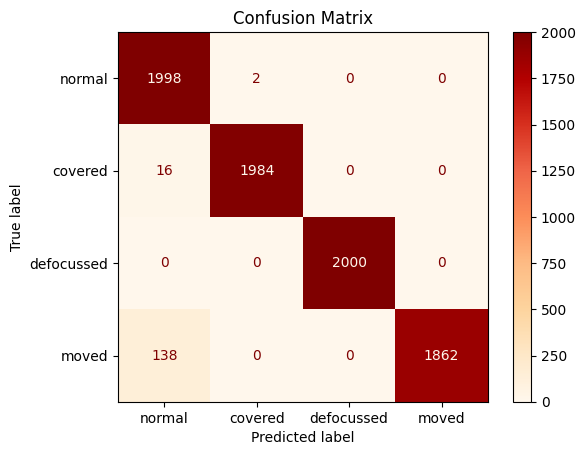

Classification Report:
              precision    recall  f1-score   support

      normal       0.93      1.00      0.96      2000
     covered       1.00      0.99      1.00      2000
  defocussed       1.00      1.00      1.00      2000
       moved       1.00      0.93      0.96      2000

    accuracy                           0.98      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.98      0.98      0.98      8000

TPR, FPR per class:
normal: TPR = 0.9990, FPR = 0.0257
covered: TPR = 0.9920, FPR = 0.0003
defocussed: TPR = 1.0000, FPR = 0.0000
moved: TPR = 0.9310, FPR = 0.0000


In [6]:
dashboard = PlotlyTrainingDashboard()
train_model(dashboard, mode='EfficientNet')

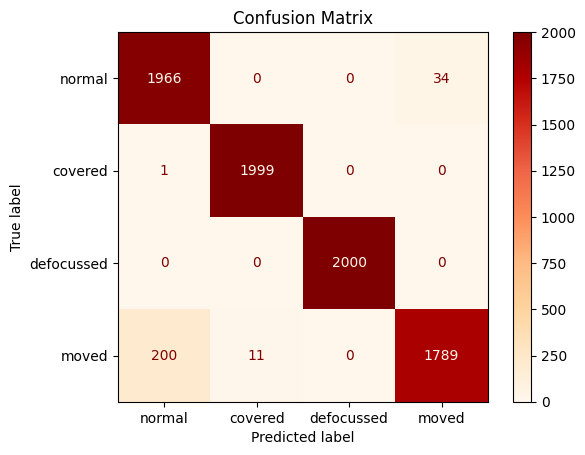

Classification Report:
              precision    recall  f1-score   support

      normal       0.91      0.98      0.94      2000
     covered       0.99      1.00      1.00      2000
  defocussed       1.00      1.00      1.00      2000
       moved       0.98      0.89      0.94      2000

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000

TPR, FPR per class:
normal: TPR = 0.9830, FPR = 0.0335
covered: TPR = 0.9995, FPR = 0.0018
defocussed: TPR = 1.0000, FPR = 0.0000
moved: TPR = 0.8945, FPR = 0.0057


In [7]:
dashboard = PlotlyTrainingDashboard()
train_model(dashboard, mode='MobileNetV2')

**Эксперимент**

Давайте проведем эксперимент и узнаем, как будет работать модель на другой камере с другим разрешением.

А также так мы проверим, не переобучилась ли наша модель.

Так как при смене камеры изменится задний фон изображений, ожидается, что класс moved будет классифицировать большую часть объектов.

Сперва проверим это с классом moved, а после проведем классификацию на 3 класса.

In [8]:
EfficientNet_path = "best_model_EfficientNet.pt"
MobileNet_path = "best_model_MobileNetV2.pt"

def test_on_camera_B(mode='EfficientNet'):
    if mode == 'EfficientNet':
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)
        model.load_state_dict(torch.load(EfficientNet_path, map_location=DEVICE))
    elif mode == 'MobileNetV2':
        model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.last_channel, 4)
        model.load_state_dict(torch.load(MobileNet_path, map_location=DEVICE))
    else: 
        raise ValueError(f"No such mode : {mode}")
    
    model = model.to(DEVICE)
    dataset = ImageDataset(base_path="UHCTD_dataset", camera_name="Camera B")
    test_loader = DataLoader(dataset.get_dataloader(mode='test').dataset, batch_size=32)
    evaluate_model(model, test_loader)

Extracted per train+test : [10000, 10000, 10000, 10000]
Extracted per val : [2000, 2000, 2000, 2000]


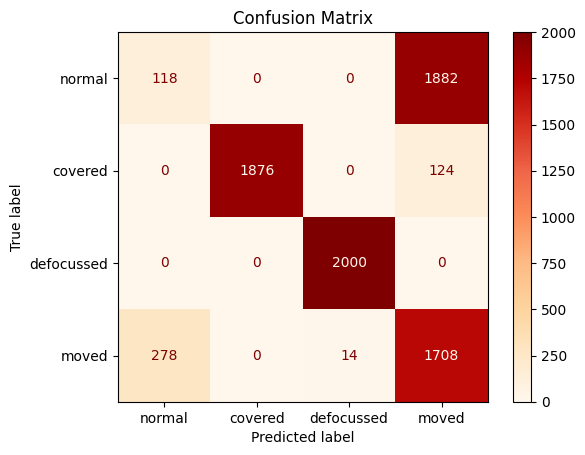

Classification Report:
              precision    recall  f1-score   support

      normal       0.30      0.06      0.10      2000
     covered       1.00      0.94      0.97      2000
  defocussed       0.99      1.00      1.00      2000
       moved       0.46      0.85      0.60      2000

    accuracy                           0.71      8000
   macro avg       0.69      0.71      0.67      8000
weighted avg       0.69      0.71      0.67      8000

TPR, FPR per class:
normal: TPR = 0.0590, FPR = 0.0463
covered: TPR = 0.9380, FPR = 0.0000
defocussed: TPR = 1.0000, FPR = 0.0023
moved: TPR = 0.8540, FPR = 0.3343


In [10]:
test_on_camera_B(mode='MobileNetV2')